## 本文链接：https://zhuanlan.zhihu.com/p/60648709

/var/folders/bk/b3m2wys54n91zrkcrlln8fpr0000gn/T/ipykernel_36244/3979402091.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_tmp = user_balance.groupby(['report_date'])['total_purchase_amt', 'total_redeem_amt'].sum()


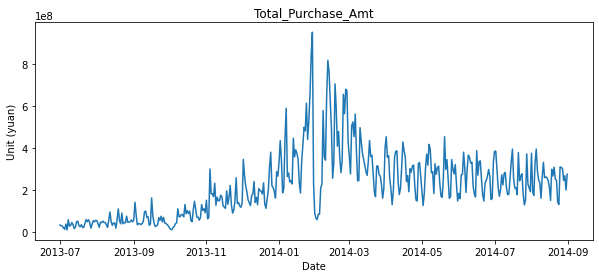

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

user_balance = pd.read_csv(r'./data/user_balance_table.csv')
df_tmp = user_balance.groupby(['report_date'])['total_purchase_amt', 'total_redeem_amt'].sum()
df_tmp.reset_index(inplace=True)

df_tmp['report_date'] = pd.to_datetime(df_tmp['report_date'], format='%Y%m%d')

df_tmp.index = df_tmp['report_date']

total_purchase_amt = plt.figure(figsize=(10, 4))
ax = total_purchase_amt.add_subplot(111)
ax.set(title='Total_Purchase_Amt',
       ylabel='Unit (yuan)', xlabel='Date')
plt.plot(df_tmp['report_date'], df_tmp['total_purchase_amt'])
plt.show()

### 从2014-04开始，趋向于稳定的震荡（均值近似为常数）。ARIMA 模型是通过寻找历史数据之间的自相关性，来预测未来（假设未来将重复历史的走势），要求序列必须是平稳的。因此我们取 2014-04-01 ~ 2014-07-31 的数据作为训练集，将 2014-08-01 ~ 2014-08-10 的数据作为测试集。

In [3]:
def generate_purchase_seq():
    dateparse = lambda dates: pd.datetime.strptime(dates, '%Y%m%d')
    user_balance = pd.read_csv('./data/user_balance_table.csv', parse_dates=['report_date'],
                               index_col='report_date', date_parser=dateparse)

    df = user_balance.groupby(['report_date'])['total_purchase_amt'].sum()
    purchase_seq = pd.Series(df, name='value')

    purchase_seq_train = purchase_seq['2014-04-01':'2014-07-31']
    purchase_seq_test = purchase_seq['2014-08-01':'2014-08-10']

    purchase_seq_train.to_csv(path_or_buf='./data/purchase_seq_train.csv', header=True)
    purchase_seq_test.to_csv(path_or_buf='./data/purchase_seq_test.csv', header=True)


generate_purchase_seq()

/var/folders/bk/b3m2wys54n91zrkcrlln8fpr0000gn/T/ipykernel_36244/3751191803.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y%m%d')


### 定义打印ADF结果函数

In [12]:
def printAdfResult(title, result):
  output = pd.DataFrame(index=['Test Statistic Value', "p-value", "Lags Used", "Number of Observations Used","Critical Value(1%)","Critical Value(5%)","Critical Value(10%)"], columns=['value'])
  output['value']['Test Statistic Value'] = result[0]
  output['value']['p-value'] = result[1]
  output['value']['Lags Used'] = result[2]
  output['value']['Number of Observations Used'] = result[3]
  output['value']['Critical Value(1%)'] = result[4]['1%']
  output['value']['Critical Value(5%)'] = result[4]['5%']
  output['value']['Critical Value(10%)'] = result[4]['10%']
  print('result for ', title)
  print(output)

### 查看一下训练集 purchase_seq_train.csv 的差分效果，并对每一次差分结果做 ADF 检验


/var/folders/bk/b3m2wys54n91zrkcrlln8fpr0000gn/T/ipykernel_36244/2509146584.py:30: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')


result for  timeseries_adf
                                value
Test Statistic Value        -2.063975
p-value                      0.259245
Lags Used                          13
Number of Observations Used       108
Critical Value(1%)          -3.492401
Critical Value(5%)          -2.888697
Critical Value(10%)         -2.581255
result for  timeseries_diff1_adf
                                value
Test Statistic Value        -6.542516
p-value                           0.0
Lags Used                          12
Number of Observations Used       109
Critical Value(1%)          -3.491818
Critical Value(5%)          -2.888444
Critical Value(10%)          -2.58112
result for  timeseries_diff2_adf
                                value
Test Statistic Value        -5.615546
p-value                      0.000001
Lags Used                          13
Number of Observations Used       108
Critical Value(1%)          -3.492401
Critical Value(5%)          -2.888697
Critical Value(10%)         -2.58

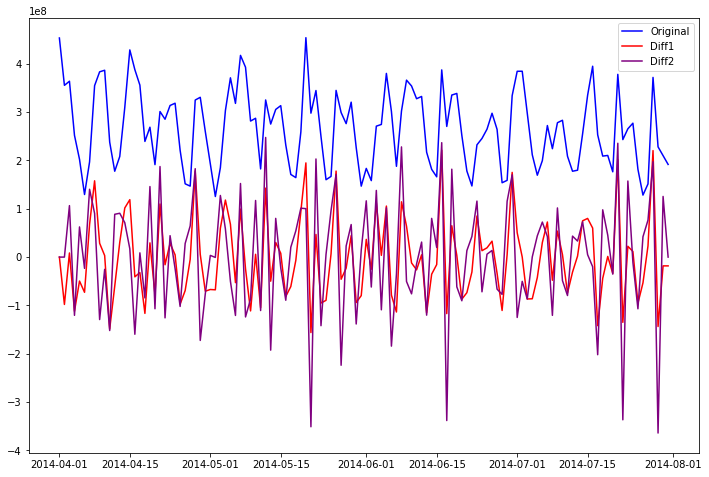

In [13]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller as ADF


def diff(timeseries):
  timeseries_diff1 = timeseries.diff(1)
  timeseries_diff2 = timeseries_diff1.diff(1)

  timeseries_diff1 = timeseries_diff1.fillna(0)
  timeseries_diff2 = timeseries_diff2.fillna(0)

  timeseries_adf = ADF(timeseries['value'].tolist())
  timeseries_diff1_adf = ADF(timeseries_diff1['value'].tolist())
  timeseries_diff2_adf = ADF(timeseries_diff2['value'].tolist())
  
  printAdfResult('timeseries_adf', timeseries_adf)
  printAdfResult('timeseries_diff1_adf', timeseries_diff1_adf)
  printAdfResult('timeseries_diff2_adf', timeseries_diff2_adf)

  plt.figure(figsize=(12, 8))
  plt.plot(timeseries, label='Original', color='blue')
  plt.plot(timeseries_diff1, label='Diff1', color='red')
  plt.plot(timeseries_diff2, label='Diff2', color='purple')
  plt.legend(loc='best')
  plt.show()


dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
purchase_seq_train = pd.read_csv('./data/purchase_seq_train.csv', parse_dates=['report_date'],
                                 index_col='report_date', date_parser=dateparse)

diff(purchase_seq_train)

### 一阶差分，已经够平稳的了

### 对序列进行一阶差分，并查看差分后序列的 ACF、PACF

/var/folders/bk/b3m2wys54n91zrkcrlln8fpr0000gn/T/ipykernel_36244/1261736406.py:11: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


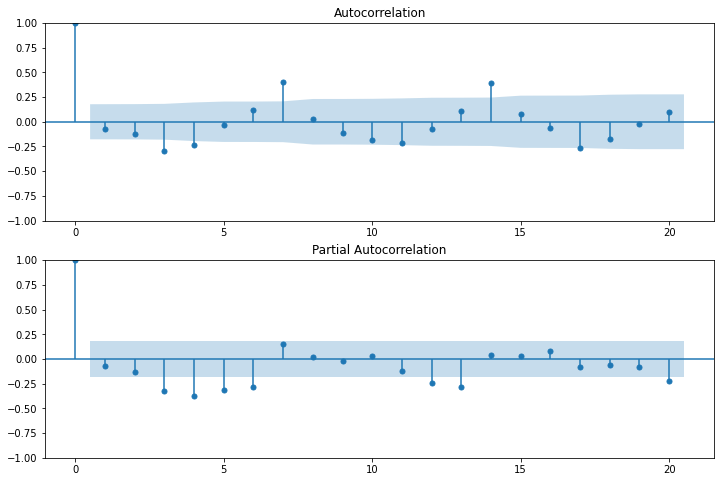

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def autocorrelation(timeseries, lags):
  fig = plt.figure(figsize=(12, 8))
  ax1 = fig.add_subplot(211)
  plot_acf(timeseries, lags=lags, ax=ax1)
  ax2 = fig.add_subplot(212)
  plot_pacf(timeseries, lags=lags, ax=ax2)
  plt.show()

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
purchase_seq_train = pd.read_csv('./data/purchase_seq_train.csv', parse_dates=['report_date'],
                                 index_col='report_date', date_parser=dateparse)

purchase_seq_train_diff = purchase_seq_train.diff(1)
purchase_seq_train_diff = purchase_seq_train_diff.fillna(0)

autocorrelation(purchase_seq_train_diff, 20)

### 从 ACF PACF 看，没有明显的拖尾或者截尾现象

### 这里我们将先通过对时间序列分解（STL），再采用 ARIMA 模型来拟合趋势序列与残差序列。

/var/folders/bk/b3m2wys54n91zrkcrlln8fpr0000gn/T/ipykernel_36244/2637421044.py:25: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')


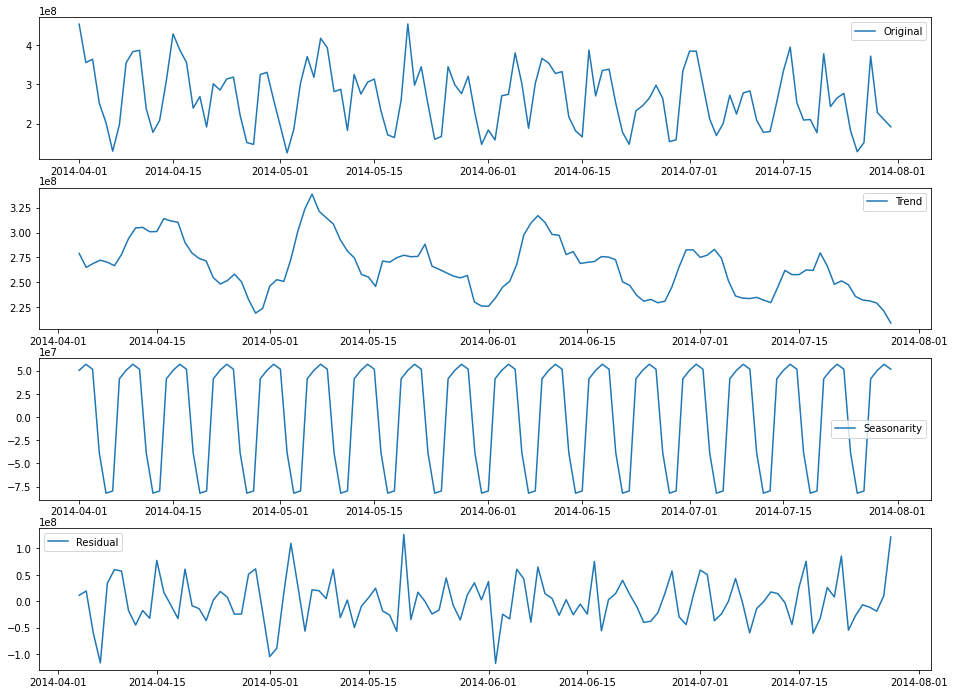

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

def decomposing(timeseries):
  decomposition = seasonal_decompose(timeseries)
  trend = decomposition.trend
  seasonal = decomposition.seasonal
  residual = decomposition.resid

  plt.figure(figsize=(16, 12))
  plt.subplot(411)
  plt.plot(timeseries, label='Original')
  plt.legend(loc='best')
  plt.subplot(412)
  plt.plot(trend, label='Trend')
  plt.legend(loc='best')
  plt.subplot(413)
  plt.plot(seasonal, label='Seasonarity')
  plt.legend(loc='best')
  plt.subplot(414)
  plt.plot(residual, label='Residual')
  plt.legend(loc='best')
  plt.show()


dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
purchase_seq_train = pd.read_csv('./data/purchase_seq_train.csv', parse_dates=['report_date'],
                                 index_col='report_date', date_parser=dateparse)

decomposing(purchase_seq_train)

### 可以看到，原序列有明显的周期性，而且是以七天为一个周期（可以将具体的数值打印出来）。因此我们只对趋势序列和残差序列去拟合，同时认为这样的周期性会延伸至2014-08-01~2014-08-10的测试集上。下面将介绍对趋势序列、残差序列的拟合过程。

result for  timeseries_adf
                                value
Test Statistic Value        -3.236849
p-value                      0.017948
Lags Used                           0
Number of Observations Used       121
Critical Value(1%)          -3.485585
Critical Value(5%)          -2.885739
Critical Value(10%)         -2.579676
result for  timeseries_diff1_adf
                                 value
Test Statistic Value        -10.571816
p-value                            0.0
Lags Used                            0
Number of Observations Used        121
Critical Value(1%)           -3.485585
Critical Value(5%)           -2.885739
Critical Value(10%)          -2.579676
result for  timeseries_diff2_adf
                                value
Test Statistic Value        -5.522044
p-value                      0.000002
Lags Used                           8
Number of Observations Used       113
Critical Value(1%)           -3.48959
Critical Value(5%)          -2.887477
Critical Value(10%)      

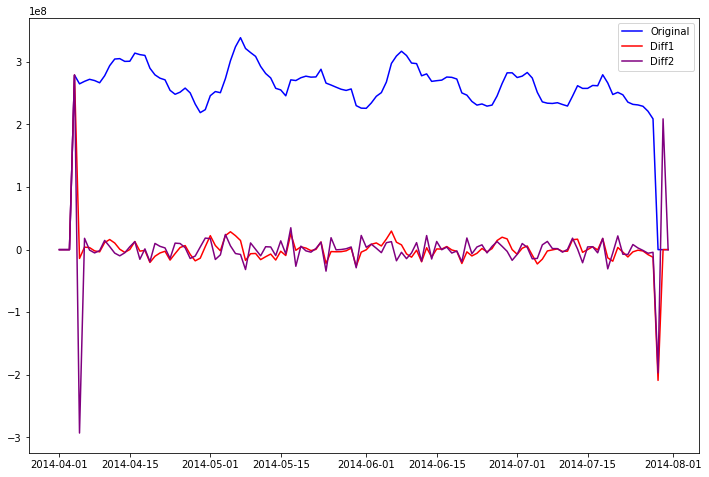

result for  timeseries_adf
                                value
Test Statistic Value        -6.290212
p-value                           0.0
Lags Used                           8
Number of Observations Used       113
Critical Value(1%)           -3.48959
Critical Value(5%)          -2.887477
Critical Value(10%)         -2.580604
result for  timeseries_diff1_adf
                                value
Test Statistic Value         -5.90315
p-value                           0.0
Lags Used                          13
Number of Observations Used       108
Critical Value(1%)          -3.492401
Critical Value(5%)          -2.888697
Critical Value(10%)         -2.581255
result for  timeseries_diff2_adf
                                value
Test Statistic Value        -6.644727
p-value                           0.0
Lags Used                          13
Number of Observations Used       108
Critical Value(1%)          -3.492401
Critical Value(5%)          -2.888697
Critical Value(10%)         -2.58

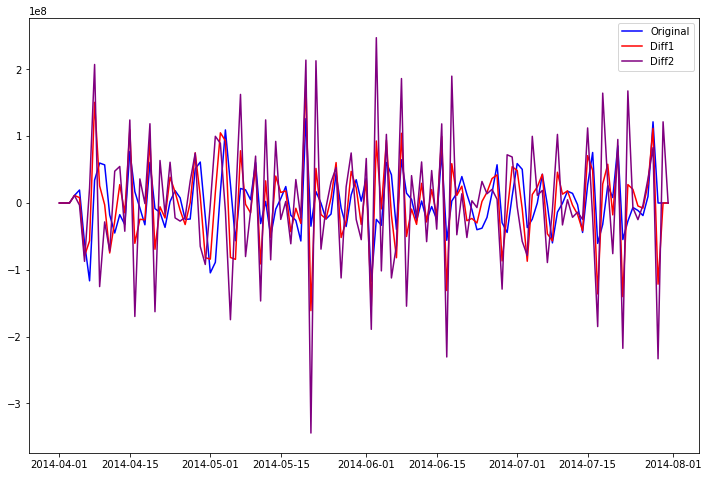

/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


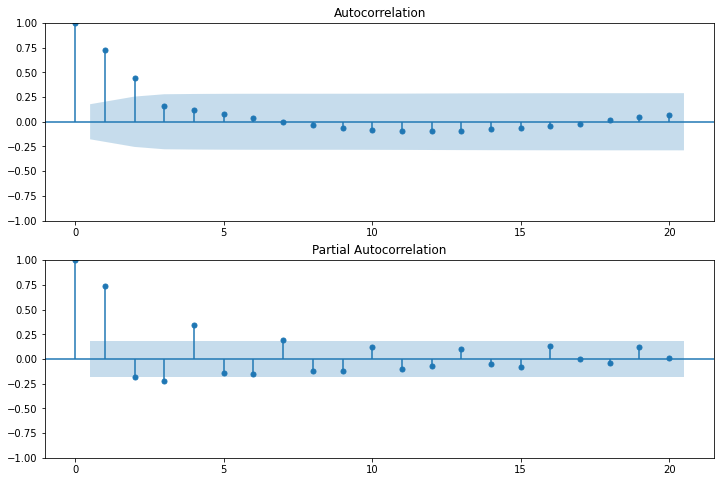

/usr/local/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


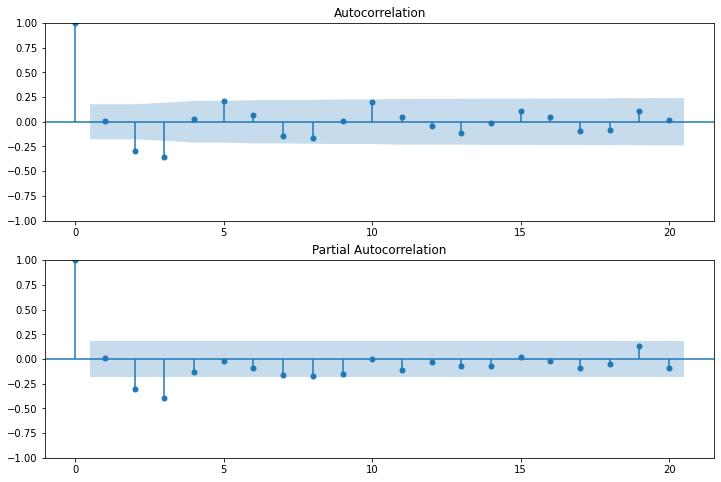

In [16]:
decomposition = seasonal_decompose(purchase_seq_train)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

trend = trend.fillna(0)
seasonal = seasonal.fillna(0)
residual = residual.fillna(0)

trend_df = trend.to_frame(name='value')
residual_df = residual.to_frame(name='value')

diff(trend_df)
diff(residual_df)

autocorrelation(trend_df, 20)
autocorrelation(residual_df, 20)

### (1) 趋势序列 ACF 有 3 阶截尾，PACF 有 2 阶拖尾。因此可以选 p=2， q=3。

### (2) 残差序列 ACF 有 4 阶拖尾，PACF 有 4 阶截尾。因此可以选 p=4， q=4。

## 试试，auto arima 找找参数

In [19]:
import pmdarima as pm

auto_arima = pm.auto_arima(trend_df, stepwise=False, seasonal=False)
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  122
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -2288.477
Date:                Sun, 12 Mar 2023   AIC                           4580.954
Time:                        21:01:17   BIC                           4586.563
Sample:                    04-01-2014   HQIC                          4583.232
                         - 07-31-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9867      0.016     60.508      0.000       0.955       1.019
sigma2      1.123e+15   2.73e-18   4.12e+32      0.000    1.12e+15    1.12e+15
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):             12245.11
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             2.63
Prob(H) (two-sided):                  0.06   Kurtosis:                        51.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [20]:
import pmdarima as pm

auto_arima = pm.auto_arima(residual_df, stepwise=False, seasonal=False)
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  122
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -2302.980
Date:                Sun, 12 Mar 2023   AIC                           4613.960
Time:                        21:01:37   BIC                           4625.176
Sample:                    04-01-2014   HQIC                          4618.516
                         - 07-31-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1027      0.082     -1.251      0.211      -0.264       0.058
ar.L2         -0.2880      0.094     -3.057      0.002      -0.473      -0.103
ar.L3         -0.3710      0.090     -4.116      0.000      -0.548      -0.194
sigma2      1.487e+15   1.87e-18   7.96e+32      0.000    1.49e+15    1.49e+15
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):                 4.23
Prob(Q):                              0.60   Prob(JB):                         0.12
Heteroskedasticity (H):               0.90   Skew:                             0.15
Prob(H) (two-sided):                  0.74   Kurtosis:                         3.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.1e+47. Standard errors may be unstable.
"""

## 开始拟合训练

In [21]:
def ARIMA_Model(timeseries, order):
  model = sm.tsa.ARIMA(timeseries, order=order)
  return model.fit()

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
purchase_seq_train = pd.read_csv('./data/purchase_seq_train.csv', parse_dates=['report_date'],
                                 index_col='report_date', date_parser=dateparse)

purchase_seq_test = pd.read_csv('./data/purchase_seq_test.csv', parse_dates=['report_date'],
                                index_col='report_date', date_parser=dateparse)

decomposition = seasonal_decompose(purchase_seq_train)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

trend_df = trend.to_frame(name='value')
residual_df = residual.to_frame(name='value')
seasonal_df = seasonal.to_frame(name='value')

trend = trend_df.fillna(0)
seasonal = seasonal_df.fillna(0)
residual = residual_df.fillna(0)



/var/folders/bk/b3m2wys54n91zrkcrlln8fpr0000gn/T/ipykernel_36244/1278842601.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
/var/folders/bk/b3m2wys54n91zrkcrlln8fpr0000gn/T/ipykernel_36244/1278842601.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')


/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, f

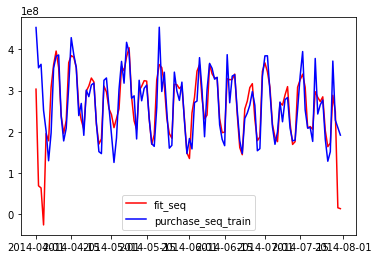

In [22]:
# 趋势序列模型训练
trend_model = ARIMA_Model(trend, (1, 0, 0))
trend_fit_seq = trend_model.fittedvalues
trend_predict_seq = trend_model.predict(start='2014-08-01', end='2014-08-10', dynamic=True)

# 残差序列模型训练
residual_model = ARIMA_Model(residual, (2, 0, 1))
residual_fit_seq = residual_model.fittedvalues
residual_predict_seq = residual_model.predict(start='2014-08-01', end='2014-08-10', dynamic=True)

# 拟合训练集
fit_seq = pd.Series(seasonal['value'], index=seasonal.index)
fit_seq = fit_seq.add(trend_fit_seq, fill_value=0)
fit_seq = fit_seq.add(residual_fit_seq, fill_value=0)

plt.plot(fit_seq, color='red', label='fit_seq')
plt.plot(purchase_seq_train, color='blue', label='purchase_seq_train')
plt.legend(loc='best')
plt.show()

/var/folders/bk/b3m2wys54n91zrkcrlln8fpr0000gn/T/ipykernel_36244/520707432.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  '2014-08-09', '2014-08-10']).apply(lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d'))


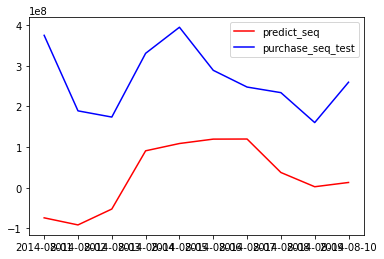

In [23]:
# 预测测试集
# 这里测试数据的周期性是根据seasonal对象打印的结果，看到里面的数据每7天一个周期，2014-08-01~2014-08-10的数据正好和2014-04-04~2014-04-13的数据一致
seasonal_predict_seq = seasonal['2014-04-04':'2014-04-13']

predict_dates = pd.Series(
    ['2014-08-01', '2014-08-02', '2014-08-03', '2014-08-04', '2014-08-05', '2014-08-06', '2014-08-07', '2014-08-08',
     '2014-08-09', '2014-08-10']).apply(lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d'))

seasonal_predict_seq.index = predict_dates

predict_seq = pd.Series(seasonal_predict_seq['value'], index=seasonal_predict_seq.index)
predict_seq = predict_seq.add(trend_predict_seq, fill_value=0)
predict_seq = predict_seq.add(residual_predict_seq, fill_value=0)

plt.plot(predict_seq, color='red', label='predict_seq')
plt.plot(purchase_seq_test, color='blue', label='purchase_seq_test')
plt.legend(loc='best')
plt.show()